In [1]:
# import the necessary libraries
import tensorflow as tf
import numpy as np
import os
import glob
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from PIL import Image, ImageOps
from tensorflow.keras.layers import LeakyReLU # activation function is different from the paper
import matplotlib.pyplot as plt # for plotting the images
from rnnconv import RnnConv # necessary for network architecture

# probability distribution for the binarizer
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

Implement necessary checks. If these checks fail, something is wrong with the system

In [2]:
print("Tensorflow version: {}".format(tf.__version__))
print("Is GPU available? {}".format(tf.config.list_physical_devices('GPU')))
print("Eager execution on? {}".format(tf.executing_eagerly()))

Tensorflow version: 2.2.0
Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution on? True


### Data Setup

The paper uses 16 iterations, but due to hardware constraints we'll use 1.

An iteration is the number of times the images goes through the encoder to the decoder, and then back out to the encoder again. The more iterations, the better the compression

In [3]:
iterations = 1

Get and begin to clean the training data

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
(train_images2, train_labels2), (test_images2, test_labels2) = datasets.cifar100.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images2, test_iamges2 = train_images2 / 255.0, test_images / 255.0

train_images = np.concatenate((train_images, train_images2) ,axis=0)
test_images = np.concatenate((test_images, test_images2), axis=0)

train_labels = np.concatenate((train_labels, train_labels2), axis=0)
test_labels = np.concatenate((test_labels, test_labels2), axis=0)

In [5]:
print("There are {} images".format(train_images.shape[0]))

There are 100000 images


### Model Architecture

In [6]:
model = tf.keras.Sequential() 
relu_amount = 0.01

# note the number of iterations here. The paper uses 16
for i in range(iterations):

    model.add(layers.Conv2D(filters=64, kernel_size=3, input_shape=(32, 32, 3), strides = (2, 2), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=256, kernel_size=3, strides=(2, 2),   padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    
    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(2, 2),   padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    
    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(2, 2),   padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))

    model.add(layers.Conv2D(filters=32, kernel_size=1,  strides = (1,1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))

    model.add(layers.Conv2D(filters=512, kernel_size=1,  strides = (1,1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    
    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=2, strides=(1, 1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))
    
    
    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))

    model.add(layers.Conv2D(filters=3, kernel_size=1, strides = (1,1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))

### Optimizer and Loss Function

The loss function in the paper uses the simple residual loss between two images. This works because they use a high number of iterations and they have a large dataset. Because we do not have these resources, the simple SSIM loss was used to train the model. The squared was added to the loss function so that lower SSIM index values could be punished more

In [7]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.9, epsilon=1e-06, amsgrad=True)

def SSIMLoss(y_true, y_pred):
    return tf.math.square(1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0)))

model.compile(optimizer=opt, loss=SSIMLoss, metrics=[SSIMLoss])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
lambda (Lambda)              (None, 1, 16, 16, 64)     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 8, 8, 256)         2950144   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 8, 8, 256)      0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 4, 4, 512)         1

Above, confirm that the number of parameters is non-zero

### Fit the model

In [8]:
model3 = model.fit(train_images, train_images, batch_size=64, epochs=3, validation_split=0.05)

Epoch 1/3
1485/1485 [==============================] - 3291s 2s/step - loss: 0.2370 - SSIMLoss: 0.2370 - val_loss: 0.1112 - val_SSIMLoss: 0.1112
Epoch 2/3
1485/1485 [==============================] - 3285s 2s/step - loss: 0.0776 - SSIMLoss: 0.0776 - val_loss: 0.0599 - val_SSIMLoss: 0.0600
Epoch 3/3
1485/1485 [==============================] - 3285s 2s/step - loss: 0.0475 - SSIMLoss: 0.0475 - val_loss: 0.0450 - val_SSIMLoss: 0.0450


### Look at the Results

In [9]:
# predict model results

from matplotlib import pyplot as plt
full = model.predict(test_images[20:30,:,:,:])

Text(0.5, 0, 'X axis')

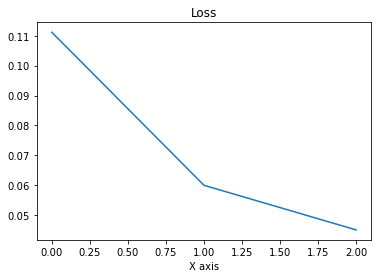

In [10]:
plt.plot(model3.history["val_SSIMLoss"])
plt.title("Loss")
plt.xlabel("X axis")

##### Before

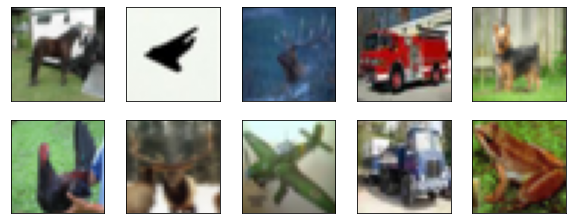

In [11]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[20:30,:,:,:][i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

#### After, Compressed Version

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


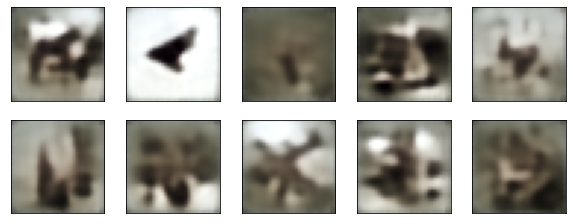

In [12]:
full_pred = full.reshape((10,32,32,3))

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(full_pred[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()